In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import os
import seaborn as sns

In [2]:
# Read CSVs
PatientConsumption = pd.read_csv('PatientConsumption 2018-2019.csv').drop_duplicates()
PurchasedOrders    = pd.read_csv('PurchasedOrders 2018-2019.csv').drop_duplicates()
IncompleteOrders   = pd.read_csv('IncompleteOrders 2018-2019.csv').drop_duplicates()
PatentDrugs        = pd.read_csv('Diccionario_v3.csv').drop_duplicates()
# Values to predict
PatientConsumption2020 = pd.read_csv('PatientConsumption 2020.csv').drop_duplicates()

# Retrieve date columns and apply to_datetime, set amount columns as numeric
date_columns   = [column for column in PatientConsumption.columns if 'Date' in column]
amount_columns = [column for column in PatientConsumption.keys() if 'Amount' in column]
PatientConsumption[date_columns]   = PatientConsumption[date_columns].apply(pd.to_datetime)
PatientConsumption[amount_columns] = PatientConsumption[amount_columns].astype(int)
# Values to predict
PatientConsumption2020[date_columns]   = PatientConsumption2020[date_columns].apply(pd.to_datetime)
PatientConsumption2020[amount_columns] = PatientConsumption2020[amount_columns].astype(int)

date_columns   = [column for column in PurchasedOrders.columns if 'Date' in column]
amount_columns = [column for column in PurchasedOrders.keys() if 'Amount' in column]
PurchasedOrders[date_columns]   = PurchasedOrders[date_columns].apply(pd.to_datetime)
PurchasedOrders[amount_columns] = PurchasedOrders[amount_columns].astype(int)

date_columns   = [column for column in IncompleteOrders.columns if 'Date' in column]
amount_columns = [column for column in IncompleteOrders.keys() if 'Amount' in column]
IncompleteOrders[date_columns]   = IncompleteOrders[date_columns].apply(pd.to_datetime)
IncompleteOrders[amount_columns] = IncompleteOrders[amount_columns].astype(int)

_______________

In [3]:
PatientConsumption.dtypes

ConsumptionDate      datetime64[ns]
Department                   object
ConsumptionNumber           float64
MedCode                     float64
MedDescription               object
AmountConsumed                int64
UnitaryCost                 float64
TotalCost                   float64
dtype: object

In [4]:
PatientConsumption2020.dtypes

ConsumptionDate      datetime64[ns]
Department                   object
ConsumptionNumber           float64
MedCode                     float64
MedDescription               object
AmountConsumed                int64
UnitaryCost                 float64
TotalCost                   float64
dtype: object

In [5]:
PurchasedOrders.dtypes

RequestNumber                    int64
RequestDate             datetime64[ns]
PurchaseNumber                 float64
OrderDate               datetime64[ns]
RequiredDeliveryDate    datetime64[ns]
SupplierName                    object
MedCode                          int64
MedDescription                  object
Outflow                        float64
AmountRequested                  int64
AmountPurchased                  int64
dtype: object

In [6]:
IncompleteOrders.dtypes

SupplierName                          object
OrderNumber                          float64
OrderDate                     datetime64[ns]
RequiredDeliveryDate          datetime64[ns]
RequestNumber                        float64
RequestDate                   datetime64[ns]
CostCenter                            object
MedCode                                int64
MedDescription                        object
InvoiceNumber                         object
ReceivedDate                  datetime64[ns]
AmountRequested                        int64
AmountPurchased                        int64
AmountReceived                         int64
OrderPercentageFulfillment           float64
dtype: object

In [7]:
PatentDrugs.dtypes

MedCode             int64
MedDescription     object
Compound           object
MedFamily          object
MedPriceMXN       float64
MinStock            int64
MaxStock            int64
dtype: object

___
## Time series

In [8]:
TopMeds=['COMBIVENT 0.5/2.5MG AMPOLLETA 2.5ML (IPRATROPIO/ SALBUTAMOL)',
        'FIRAC PLUS 100MG AMP (CLONIXINATO LISINA/PARGEVER)',
        'FLIXOTIDE 2MG AMP 2ML (FLUTICASONA)',
        'SOMAZINA 1G AMP 4ML (CITICOLINA)',
        'INDAFLEX 2.5% CREMA 40G TUBO(INDOMETACINA)',
        'MYDOCALM A C/30 CAPS TOLPERISONA /PARACETAMOL',
        'VANCOCIN CP 1G AMP (VANCOMICINA)',
        'COMBIVENT RESPIMAT 1.68/8.77MG C/DOSIF.(IPRATRO./ SALBUTAMOL',
        'LIPITOR 80MG C/30 TAB(ATORVASTATINA)']

TopMedCodes = PatentDrugs[PatentDrugs['MedDescription'].isin(TopMeds)]['MedCode']
PatentDrugs[PatentDrugs['MedDescription'].isin(TopMeds)]

,MedCode,MedDescription,Compound,MedFamily,MedPriceMXN,MinStock,MaxStock
14,3300115,INDAFLEX 2.5% CREMA 40G TUBO(INDOMETACINA),INDOMETACINA,Sistema musculoesquelético,719.0,21,59
37,3300142,LIPITOR 80MG C/30 TAB(ATORVASTATINA),ATORVASTATINA,Sistema cardiovascular,801.0,5,13
202,3300663,VANCOCIN CP 1G AMP (VANCOMICINA),VANCOMICINA,Antiinfecciosos para uso sistémico,1059.0,26,74
517,3301778,FLIXOTIDE 2MG AMP 2ML (FLUTICASONA),FLUTICASONA,Sistema respiratorio,720.5,118,306
548,3301771,SOMAZINA 1G AMP 4ML (CITICOLINA),CITICOLINA,Sistema nervioso,209.5,55,125
631,3302307,FIRAC PLUS 100MG AMP (CLONIXINATO LISINA/PARGE...,CLONIXINATO LISINA/PARGEVER,Tracto alimentario y metabolismo,152.5,29,84
795,3302934,COMBIVENT RESPIMAT 1.68/8.77MG C/DOSIF.(IPRATR...,IPRATROPIO/ SALBUTAMOL,Sistema respiratorio,669.5,4,8
1495,3500322,MYDOCALM A C/30 CAPS TOLPERISONA /PARACETAMOL,MYDOCALM,Sistema musculoesquelético,613.0,52,114
1585,3302669,COMBIVENT 0.5/2.5MG AMPOLLETA 2.5ML (IPRATROPI...,IPRATROPIO/ SALBUTAMOL,Sistema respiratorio,528.5,591,1608


In [9]:
# Consumed
MedConsumption = pd.merge(PatientConsumption, PatentDrugs[['MedCode','MedFamily','Compound']], on='MedCode', how='left')
# Requested, Purchased
MedOrders = pd.merge(PurchasedOrders, PatentDrugs[['MedCode','MedFamily','Compound']], on='MedCode', how='left')
MedOrders['YearMonth'] = pd.to_datetime(MedOrders['RequestDate'].dt.year*100+MedOrders['RequestDate'].dt.month, format='%Y%m')
# Incomplete
MedIncompleteOrders = pd.merge(IncompleteOrders[IncompleteOrders['RequestNumber']!=0], PatentDrugs[['MedCode','MedFamily','Compound']], on='MedCode', how='left')
MedIncompleteOrders['YearMonth'] = pd.to_datetime(MedIncompleteOrders['RequestDate'].dt.year*100+MedIncompleteOrders['RequestDate'].dt.month, format='%Y%m')

In [10]:
AmountRequested = MedOrders[['YearMonth','RequestNumber','MedCode','AmountRequested']].drop_duplicates()
AmountPurchased = MedOrders.groupby(['YearMonth','RequestNumber','MedCode']).sum()['AmountPurchased'].reset_index()
AmountReceived = MedIncompleteOrders.groupby(['YearMonth','RequestNumber','MedCode']).sum()['AmountReceived'].reset_index()

# Merge columns
df = pd.merge(AmountRequested, AmountPurchased, on=['YearMonth','RequestNumber','MedCode'], how='left')
df = pd.merge(df, AmountReceived, on=['YearMonth','RequestNumber','MedCode'], how='left')
# if AmountReceived.isna() : order is complete
df['AmountReceived'] = df.apply(lambda x: x['AmountPurchased'] if pd.isna(x['AmountReceived']) else x['AmountReceived'], axis=1)
# compute shortage amount
df['AmountMissing'] = df['AmountRequested'] - df['AmountReceived']

df[(df['AmountPurchased']!=df['AmountReceived']) & (df['AmountRequested']!=df['AmountPurchased'])].head()

,YearMonth,RequestNumber,MedCode,AmountRequested,AmountPurchased,AmountReceived,AmountMissing
438,2018-01-01,52936,3300586,1,2,0.0,1.0
677,2018-01-01,53062,3300627,10,19,1.0,9.0
717,2018-01-01,53076,3300952,15,30,0.0,15.0
1975,2018-03-01,53801,3305045,20,270,0.0,20.0
2069,2018-03-01,53877,3300072,18,20,0.0,18.0


In [11]:
AmountOrder = df.groupby(['YearMonth','MedCode']).sum()[['AmountRequested','AmountPurchased','AmountReceived','AmountMissing']].reset_index()
AmountOrder.head(5)

,YearMonth,MedCode,AmountRequested,AmountPurchased,AmountReceived,AmountMissing
0,2018-01-01,1000268,15,18,18.0,-3.0
1,2018-01-01,2900193,2,2,2.0,0.0
2,2018-01-01,2900517,7,6,5.0,2.0
3,2018-01-01,3300018,2,2,0.0,2.0
4,2018-01-01,3300029,1,1,1.0,0.0


In [12]:
AmountConsumed = MedConsumption.groupby(['ConsumptionDate','MedCode']).sum()['AmountConsumed'].reset_index()
AmountConsumed['YearMonth'] = pd.to_datetime(AmountConsumed['ConsumptionDate'].dt.year*100+AmountConsumed['ConsumptionDate'].dt.month, format='%Y%m')
AmountConsumed = AmountConsumed.loc[:, ['YearMonth','MedCode','AmountConsumed']]
AmountConsumed.head()

,YearMonth,MedCode,AmountConsumed
0,2018-01-01,1000268.0,22
1,2018-01-01,2900193.0,2
2,2018-01-01,2900517.0,3
3,2018-01-01,3300018.0,1
4,2018-01-01,3300029.0,1


In [13]:
MonthlyMeds = pd.merge(AmountOrder, AmountConsumed, on=['YearMonth','MedCode'], how='outer')
# fill AmountConsumed.isna() with zeros
#MonthlyMeds['AmountConsumed'] = MonthlyMeds['AmountConsumed'].fillna(0)
MonthlyMeds = MonthlyMeds.fillna(0)
MonthlyMeds.head()

,YearMonth,MedCode,AmountRequested,AmountPurchased,AmountReceived,AmountMissing,AmountConsumed
0,2018-01-01,1000268,15.0,18.0,18.0,-3.0,22.0
1,2018-01-01,2900193,2.0,2.0,2.0,0.0,2.0
2,2018-01-01,2900517,7.0,6.0,5.0,2.0,3.0
3,2018-01-01,3300018,2.0,2.0,0.0,2.0,1.0
4,2018-01-01,3300029,1.0,1.0,1.0,0.0,1.0


In [14]:
MonthlyMeds = pd.merge(MonthlyMeds, PatentDrugs[['MedCode','MedDescription']], on='MedCode', how='left')
MonthlyMeds.head(5)

,YearMonth,MedCode,AmountRequested,AmountPurchased,AmountReceived,AmountMissing,AmountConsumed,MedDescription
0,2018-01-01,1000268,15.0,18.0,18.0,-3.0,22.0,HALOPERIL 5MG/ML AMP IM (HALOPERIDOL)
1,2018-01-01,2900193,2.0,2.0,2.0,0.0,2.0,REFRESH TEARS GTS 15ML (CARBOXIMETILCELULOSA S...
2,2018-01-01,2900517,7.0,6.0,5.0,2.0,3.0,ALBUMINA DE HUEVO 400GR OVOPROT
3,2018-01-01,3300018,2.0,2.0,0.0,2.0,1.0,LYRICA 150MG C/14 TAB(PREGABALINA)
4,2018-01-01,3300029,1.0,1.0,1.0,0.0,1.0,ADIMOD SOLUCION 800MG/7ML CAJA C/10 FCO (PIDOT...


In [27]:
# Values to predict
MedConsumption2020 = pd.merge(PatientConsumption2020, PatentDrugs[['MedCode','MedFamily','Compound']], on='MedCode', how='left')
AmountConsumed2020 = MedConsumption2020.groupby(['ConsumptionDate','MedCode']).sum()['AmountConsumed'].reset_index()
AmountConsumed2020['YearMonth'] = pd.to_datetime(AmountConsumed2020['ConsumptionDate'].dt.year*100+AmountConsumed2020['ConsumptionDate'].dt.month, format='%Y%m')
AmountConsumed2020 = AmountConsumed2020.loc[:, ['YearMonth','MedCode','AmountConsumed']]
AmountConsumed2020 = pd.merge(AmountConsumed2020, PatentDrugs[['MedCode','MedDescription']], on='MedCode', how='left')
AmountConsumed2020.head()

,YearMonth,MedCode,AmountConsumed,MedDescription
0,2020-01-01,1000110.0,2,NaN
1,2020-01-01,1000268.0,44,HALOPERIL 5MG/ML AMP IM (HALOPERIDOL)
2,2020-01-01,2400207.0,1,LENEDA 1%GELTB 30G
3,2020-01-01,2900217.0,1,"HIPOGLOS TUBO 110G (OXIDO DE ZINC/VITAMINA A,E)"
4,2020-01-01,2900557.0,44,ABINTRA POLVO 27G (SUPLEMENTO ALIMENTICIO)


In [28]:
alldates_df = pd.DataFrame()
for Month in AmountConsumed2020['YearMonth'].unique():
    temp_df = AmountConsumed2020[AmountConsumed2020['YearMonth']==Month]
    temp_df = pd.merge(temp_df, PatentDrugs[['MedCode','MedDescription']], on=['MedCode','MedDescription'], how='outer')
    temp_df['YearMonth'] = Month
    temp_df['AmountConsumed'] = temp_df['AmountConsumed'].fillna(0)
    alldates_df = pd.concat([alldates_df, temp_df])
AmountConsumed2020 = alldates_df
AmountConsumed2020['YearMonth'].value_counts()

2020-03-01    1709
2020-02-01    1708
2020-01-01    1701
Name: YearMonth, dtype: int64

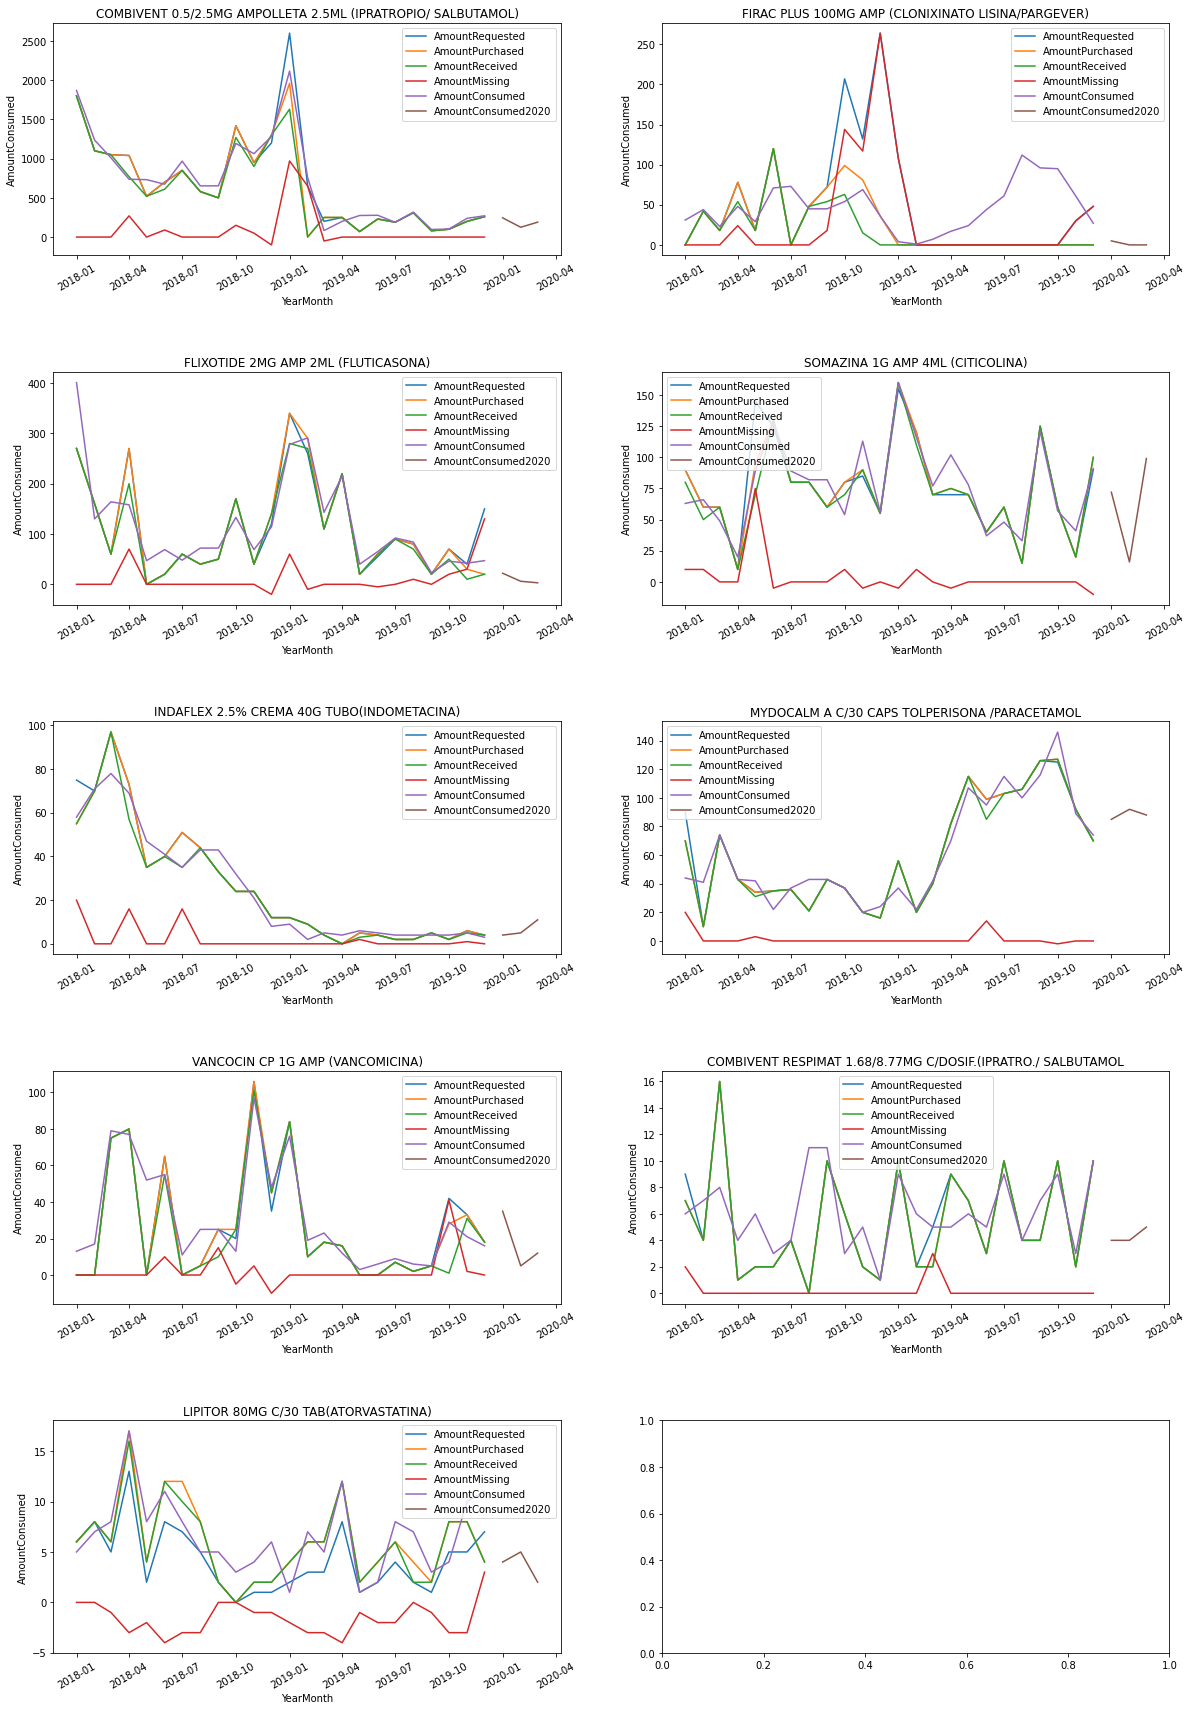

In [29]:
# Plot top Meds
fig, axes = plt.subplots(5, 2, figsize=(20,30))
fig.subplots_adjust(hspace=0.5)
for ax, MedCode in zip(axes.flatten(), TopMeds):
    sns.lineplot(data=MonthlyMeds[MonthlyMeds["MedDescription"]==MedCode], x='YearMonth', y='AmountRequested', ax=ax)
    sns.lineplot(data=MonthlyMeds[MonthlyMeds["MedDescription"]==MedCode], x='YearMonth', y='AmountPurchased', ax=ax)
    sns.lineplot(data=MonthlyMeds[MonthlyMeds["MedDescription"]==MedCode], x='YearMonth', y='AmountReceived', ax=ax)
    sns.lineplot(data=MonthlyMeds[MonthlyMeds["MedDescription"]==MedCode], x='YearMonth', y='AmountMissing', ax=ax)
    sns.lineplot(data=MonthlyMeds[MonthlyMeds["MedDescription"]==MedCode], x='YearMonth', y='AmountConsumed', ax=ax)
    # Values to predict
    sns.lineplot(data=AmountConsumed2020[AmountConsumed2020["MedDescription"]==MedCode], x='YearMonth', y='AmountConsumed', ax=ax)
    ax.legend(["AmountRequested","AmountPurchased",'AmountReceived','AmountMissing','AmountConsumed','AmountConsumed2020'])
    #ax.legend(["AmountRequested","AmountPurchased",'AmountReceived','AmountMissing','AmountConsumed'])
    ax.tick_params('x', labelrotation=30)
    ax.set(title=MedCode)

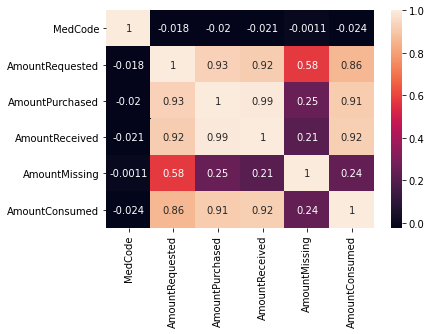

In [18]:
plt.figure(figsize=(6,4))
sns.heatmap(data=MonthlyMeds.corr(), annot=True);

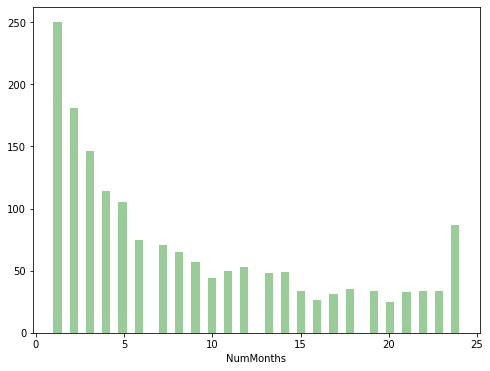

In [19]:
NumMonths = MonthlyMeds.groupby(['MedCode','YearMonth']).count().reset_index().groupby('MedCode').count()['YearMonth'].sort_values(ascending=False).rename('NumMonths')

plt.figure(figsize=(8,6))
sns.distplot(NumMonths, bins=50, color='g', kde=False);

___

# Outflow analysis

In [18]:
AmountConsumed = MedConsumption.groupby(['ConsumptionDate','MedDescription']).sum()['AmountConsumed'].reset_index()
AmountConsumed['YearMonth'] = pd.to_datetime(AmountConsumed['ConsumptionDate'].dt.year*100+AmountConsumed['ConsumptionDate'].dt.month, format='%Y%m')
AmountConsumed = AmountConsumed.loc[:, ['YearMonth','MedDescription','AmountConsumed']]
AmountConsumed.head()

,YearMonth,MedDescription,AmountConsumed
0,2018-01-01,ACC 200MG C/20 TAB EFERV (ACETILCISTEINA),1
1,2018-01-01,ACC 600MG TAB EFERV (ACETILCISTEINA),2
2,2018-01-01,ACELER CO 2% CREMA 15G(ACIDO FUSIDICO/BETAMETA...,2
3,2018-01-01,ACETA DIAZOL 250MG C/30 TAB(ACETAZOLAMIDA),2
4,2018-01-01,ACTRON 200 200MG C/10 CAPS (IBUPROFENO),1


In [19]:
AmountOutflow = MedOrders[['YearMonth','RequestDate','RequestNumber','MedDescription','Outflow']].drop_duplicates()
AmountOutflow = AmountOutflow.groupby(['YearMonth','MedDescription']).sum()['Outflow'].reset_index()
AmountOutflow.head()

,YearMonth,MedDescription,Outflow
0,2018-01-01,A.S. COR (NORFENEFRINA) 1 G/100 ML GOTAS 24 ML,1077.0
1,2018-01-01,ACANOL (LOPERAMIDA) 2MG TAB C/12,571.0
2,2018-01-01,ACC (ACETILCISTEINA) 600MG TAB EFERV C/20,198.0
3,2018-01-01,ACETA DIAZOL (ACETAZOLAMIDA) 250MG TAB C/30,460.0
4,2018-01-01,ACTRON (IBUPROFENO) 400MG CAP C/10,1457.0


In [20]:
plot_df = pd.merge(AmountConsumed, AmountOutflow, on=['YearMonth','MedDescription'], how='outer')
plot_df = plot_df[plot_df['YearMonth']>pd.to_datetime('2019-05-31')].fillna(0)
#plot_df = plot_df.fillna(0)
plot_df.head(5)

,YearMonth,MedDescription,AmountConsumed,Outflow
9274,2019-06-01,A.S. COR (NORFENEFRINA) 1 G/100 ML GOTAS 24 ML,2.0,4.0
9275,2019-06-01,ABRAXUS (ALBUMINA-PACLITAXEL) 100MG/16.7ML FAM,11.0,0.0
9276,2019-06-01,ACC (ACETILCISTEINA) 600MG TAB EFERV C/20,1.0,2.0
9277,2019-06-01,ACTRON (IBUPROFENO) 400MG CAP C/10,1.0,1.0
9278,2019-06-01,ACTRON (IBUPROFENO) 600MG CAP C/10,52.0,30.0


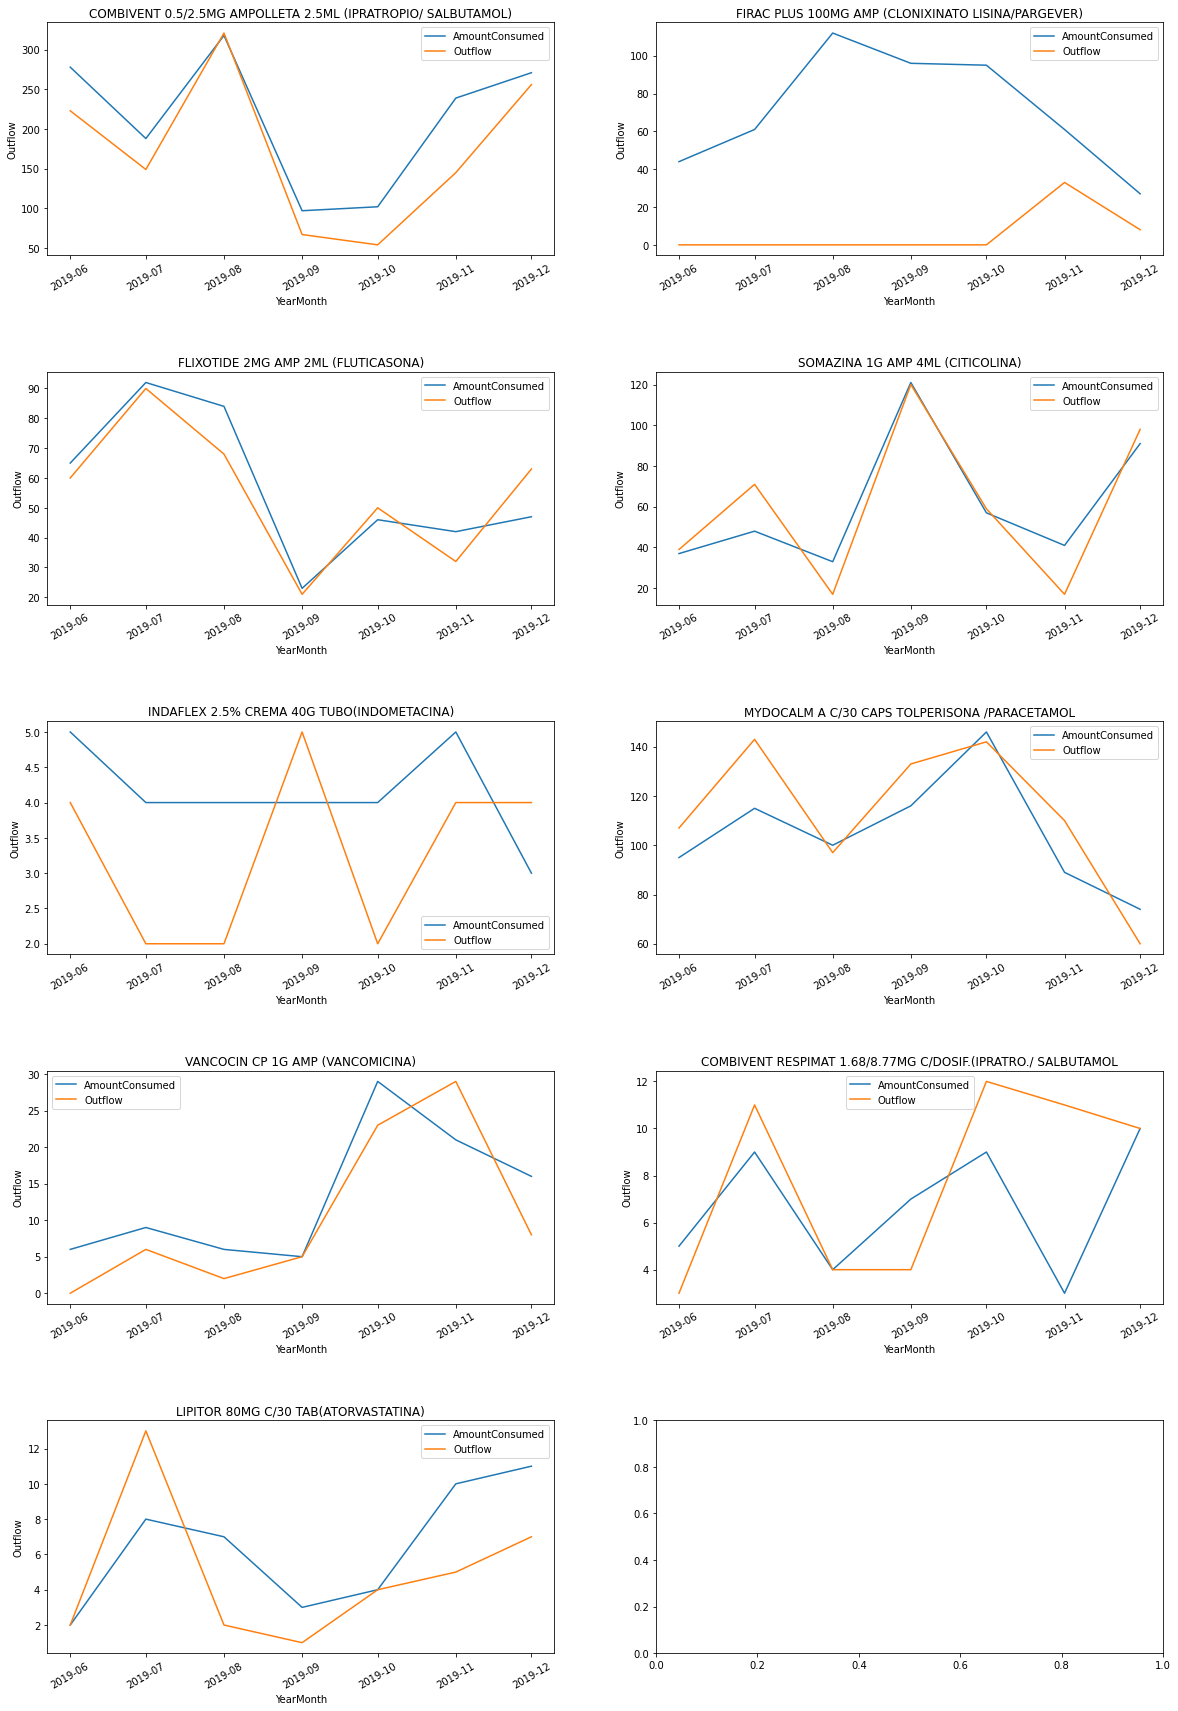

In [22]:
fig, axes = plt.subplots(5, 2, figsize=(20,30))
fig.subplots_adjust(hspace=0.5)
for ax, MedCode in zip(axes.flatten(), TopMeds):
    sns.lineplot(data=plot_df[plot_df["MedDescription"]==MedCode], x='YearMonth', y='AmountConsumed', ax=ax)
    sns.lineplot(data=plot_df[plot_df["MedDescription"]==MedCode], x='YearMonth', y='Outflow', ax=ax)
    ax.legend(["AmountConsumed","Outflow"])
    ax.tick_params('x', labelrotation=30)
    ax.set(title=MedCode)

___